In [ ]:
# # ESE 5390 Lab 4

# This lab will walk through an example of pruning a model to reduce the size of the network while mitigating accuracy loss.
# The benefits of pruning include lower storage costs and possibly lower computation cost for optimized architectures.

# This lab makes heavy use of prior labs and tutorials. Please make sure to review these prior labs and tutorials while completing this lab. 

# ## Environment

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import copy
import torch.nn.utils.prune as prune
from torchvision import datasets, models, transforms
from pathlib import Path
import os
import time
import matplotlib.pyplot as plt

!rm data || rm -rf data
!mkdir data
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
import gc
torch.manual_seed(0)
np.random.seed(0)

rm: cannot remove 'data': No such file or directory
PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [ ]:
device_to_use = 'cuda'
# device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Mount data directory to google drive
from google.colab import drive
# drive.mount('./drive')

# # Copy to local for faster extraction
# !cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_img_val.tar ./data
# !cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t3.tar.gz ./data
# !cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t12.tar.gz ./data

drive.mount('./drive', force_remount=True)
!cp /content/drive/Shareddrives/539/ILSVRC2012_img_val.tar ./data

!cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t3.tar.gz ./data

!cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t12.tar.gz ./data
print('Finished copying from Drive to local.')

Mounted at ./drive
Finished copying from Drive to local.


In [ ]:
# Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# Create validation dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, num_workers=2)

print(f'Number of validation images: {len(val_dataset)}')

Number of validation images: 50000


In [ ]:
# Put your reusable functions here.
# You can copy functions from previous labs and tutorials.
def validate_model(model, dataloader, n=1024, device = 'cpu'):
      model.eval()
      running_corrects = 0
      total = 0

      # Move model to device (CPU or GPU)
      # One time to amortize data movement
      dev = torch.device(device)
      model.to(dev)

      # Iterate over data stopping early if n is set
      t1 = time.time()
      for i, (inputs, labels) in enumerate(dataloader):
          if (n is not None and i >= n):
              break
          # Send inputs to device
          inputs = inputs.to(dev)

          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          
          """
          """
          temp = labels.data
          if(device=="cuda"):
            temp = temp.to(device="cuda")


          # Gather statistics
          running_corrects += torch.sum(predicted == temp)
          total += inputs.size()[0]       # get batch size

          if i % 200 == 199:
              acc = 100 * running_corrects.double() / total
              print(f'[{i + 1}] {acc:.4f}%')
      t2 = time.time()
      exe_time = t2-t1
      epoch_acc = 100 * running_corrects.double() / total
      del model
      del inputs
      gc.collect()  
      torch.cuda.empty_cache()
      return epoch_acc, exe_time
def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return model_size
    #TODO plot the relative accuracy, relative run time, and relative model size
def plot_global(ip, title):  
    top1_acc = [orig_acc.cpu().item()]
    top1_acc_rel = [100] #change based on ed post
    for each in ip:
      top1_acc.append(ip[each]['top1_acc'].cpu().item())
      top1_acc_rel.append(ip[each]['top1_acc_rel'].cpu().item())
    x = list(range(0,50,5))
    fig = plt.figure(figsize=(20,4))
    fig.add_subplot(1, 3, 1)
    plt.plot(x, top1_acc)
    plt.title('top1_acc_'+title)
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    fig.add_subplot(1,3,2)
    plt.plot(x, top1_acc_rel, color = 'orange')
    plt.title('top1_acc_rel_'+title)
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    fig.add_subplot(1,3,3)
    plt.plot(x, top1_acc, label = 'top1_acc')
    plt.plot(x, top1_acc_rel, label = 'top1_acc_rel')
    plt.title(title+' both')
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    plt.legend()
def plot_layer(ip, title):  
    top1_acc = [orig_acc.cpu().item()]
    top1_acc_rel = [100] #change based on ed post
    for each in ip:
      top1_acc.append(ip[each]['top1_acc'].cpu().item())
      top1_acc_rel.append(ip[each]['top1_acc_rel'].cpu().item())
    x = list(range(0,50,5))
    fig = plt.figure(figsize=(20,4))
    fig.add_subplot(1, 3, 1)
    plt.plot(x, top1_acc)
    plt.title('top1_acc_'+title)
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    fig.add_subplot(1,3,2)
    plt.plot(x, top1_acc_rel, color = 'orange')
    plt.title('top1_acc_rel_'+title)
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    fig.add_subplot(1,3,3)
    plt.plot(x, top1_acc, label = 'top1_acc')
    plt.plot(x, top1_acc_rel, label = 'top1_acc_rel')
    plt.title(title+' both')
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    plt.legend()
def plot_hardened(ip, title):
  top1_acc = [orig_acc.cpu().item()]
  runtime = [orig_time]
  size = [orig_size]
  for each in ip:
    top1_acc.append(ip[each]['top1_acc_rel'].cpu().item())
    runtime.append(ip[each]['run_time'])
    size.append(ip[each]['model_size'])
  x = list(range(0,50,5))
  fig = plt.figure(figsize=(20,4))
  fig.add_subplot(1, 3, 1)
  plt.plot(x, top1_acc)
  plt.title('accuracy relative % '+title)
  plt.xlabel('weights pruned %')
  plt.ylabel('accuracy')
  fig.add_subplot(1,3,2)
  runtime = [(x*100)/orig_time for x in runtime]
  plt.plot(x, runtime)
  plt.title('runtime relative '+title)
  plt.xlabel('weights pruned %')
  plt.ylabel('runtime relative % in sec')
  fig.add_subplot(1,3,3)
  rel_size = [(x*100)/orig_size for x in size]
  plt.plot(x,rel_size)
  plt.title('size relative %'+title)
  plt.xlabel('weights pruned %')
  plt.ylabel('size % in MB')
  plt.legend()
def plot_channel(ip, title):  
    top1_acc = [orig_acc.cpu().item()]
    top1_acc_rel = [100] #change based on ed post
    for each in ip:
      top1_acc.append(ip[each]['top1_acc'].cpu().item())
      top1_acc_rel.append(ip[each]['top1_acc_rel'].cpu().item())
    x = list(range(0,50,5))
    fig = plt.figure(figsize=(20,4))
    fig.add_subplot(1, 3, 1)
    plt.plot(x, top1_acc)
    plt.title('top1_acc_'+title)
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    fig.add_subplot(1,3,2)
    plt.plot(x, top1_acc_rel, color = 'orange')
    plt.title('top1_acc_rel_'+title)
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    fig.add_subplot(1,3,3)
    plt.plot(x, top1_acc, label = 'top1_acc')
    plt.plot(x, top1_acc_rel, label = 'top1_acc_rel')
    plt.title(title+' both')
    plt.xlabel('weights pruned %')
    plt.ylabel('top1 accuracy')
    plt.legend()
# def nonzero(ip):
#   nz = np.array([])
#   for each in ip:
#     # print(each.shape)
#     x = int(torch.equal(each, torch.zeros(each.shape).cuda()))
#     if(x==0): y=0
#     if(x==1): y=1
#     np.append(nz,y)
#     # nz_c = torch.count_nonzero(each)
#     # nz = torch.nonzero(each)
#     # print(each, nz, nz_c)
#   return(int(np.sum(nz)))
def nonzero(ip):
  count = 0
  for each in ip:
    zeros = torch.zeros(each.shape).cuda()
    if(torch.equal(zeros, each)): count+=1
  return count


## Question 1: Global Pruning

- Perform pruning using `prune.global_unstructured` on a pretrained VGG16 using various sparsity targets.
- The models should be pruned away at 5% increments from 5% to 45% total pruning of the model.
- Save a copy of each pruned model in a dictionary.
- Plot the top-1 accuracy against weight pruned from 0% to 45% (use the original VGG16 for 0%).

In [ ]:
orig_model = models.vgg16(pretrained = True)#TODO: load pretrained model
orig_model.eval()
orig_acc, orig_time = validate_model(orig_model, val_dataloader, 1024, device = device_to_use)
print(f'Validation Finished. Original Time: {orig_time:.1f}s. Original Accuracy: {orig_acc:.1f}%')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.0000%
[1000] 87.4000%
Validation Finished. Original Time: 20.1s. Original Accuracy: 87.3%


In [ ]:
orig_size = get_size_of_model(orig_model)
print(orig_size)

553.440773


In [ ]:
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
global_pruning = {} # Dictionary to store global pruning results
for prune_rate in prune_rate_list:
    model = models.vgg16(pretrained = True) #TODO: load pretrained model
    parameter_to_prune = (
        (model.features[0], 'weight'), # conv1 of VGG16
        (model.features[2], 'weight'),
        (model.features[5], 'weight'),
        (model.features[7], 'weight'),
        (model.features[10], 'weight'),
        (model.features[12], 'weight'),
        (model.features[14], 'weight'),
        (model.features[17], 'weight'),
        (model.features[19], 'weight'),
        (model.features[21], 'weight'),
        (model.features[24], 'weight'),
        (model.features[26], 'weight'),
        (model.features[28], 'weight'),
        (model.classifier[0], 'weight'),
        (model.classifier[3], 'weight'),
        (model.classifier[6], 'weight')
        #TODO: Add more layers to prune
    )
    #TODO: Prune model
    prune.global_unstructured(parameter_to_prune,pruning_method=prune.L1Unstructured,amount=prune_rate/100.0,)
    #TODO: make the pruning permanent to increase speed
    for param, name in parameter_to_prune:
      prune.remove(param, name)
    global_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    global_pruning[prune_rate]['model'] = model.state_dict() # Copy pruned model to dictionary
    # TODO Run validation on the pruned model
    pruned_acc, pruned_time = validate_model(model, val_dataloader, 1024, device = device_to_use)
    del model
    print(f'Validation Finished. Pruned Time: {pruned_time:.1f}s. Pruned Accuracy: {pruned_acc:.1f}%')
    print(f'Speedup: {orig_time/pruned_time}x. Accuracy drop: {orig_acc-pruned_acc}%')
    global_pruning[prune_rate]['top1_acc'] = pruned_acc # TODO fill with top1 accuracy
    global_pruning[prune_rate]['top1_acc_rel'] = pruned_acc/orig_acc*100 # Percent accuracy compared to original model
    print(f'Top1 accuracy for prune amount {prune_rate}%: {global_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {global_pruning[prune_rate]["top1_acc_rel"]}%')

# TODO plot the results

[200] 85.5000%
[400] 81.7500%
[600] 84.6667%
[800] 86.8750%
[1000] 87.3000%
Validation Finished. Pruned Time: 11.0s. Pruned Accuracy: 87.2%
Speedup: 1.5462840979138224x. Accuracy drop: 0.09765625%
Top1 accuracy for prune amount 5%: 87.20703125%
Top1 accuracy (rel) for prune amount 5%: 99.88814317673378%
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.1250%
[1000] 87.5000%
Validation Finished. Pruned Time: 11.0s. Pruned Accuracy: 87.4%
Speedup: 1.5405732051653367x. Accuracy drop: -0.09765625%
Top1 accuracy for prune amount 10%: 87.40234375%
Top1 accuracy (rel) for prune amount 10%: 100.11185682326622%
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.1250%
[1000] 87.5000%
Validation Finished. Pruned Time: 11.2s. Pruned Accuracy: 87.4%
Speedup: 1.5229304160007409x. Accuracy drop: -0.09765625%
Top1 accuracy for prune amount 15%: 87.40234375%
Top1 accuracy (rel) for prune amount 15%: 100.11185682326622%
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.1250%
[1000] 87.5000%
V

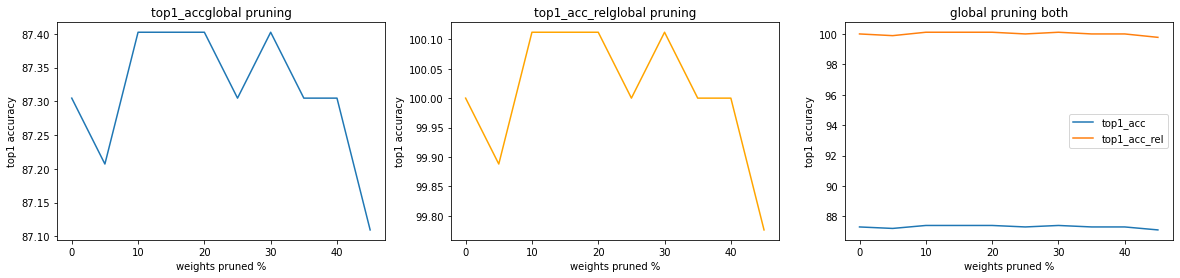

In [ ]:
plot_global(global_pruning, 'global pruning')

## Question 2: Layer-wise Pruning

- Perform pruning using `prune.l1_unstructured` on each layer of pretrained VGG16 using various sparsity targets.
- Each layer should be pruned away at 5% increments from 5% to 45% total pruning of the model.
- Save a copy of each pruned model in a dictionary.
- Plot the top-1 accuracy against weight pruned from 0% to 45% (use the original VGG16 for 0%).
- What do you observe? Why does layer-wise pruning perform better/worse than global pruning?
<br>
***********************
global pruning seems to perform better as the accuracy is not dropping off.Layer wise drops off to 96% of the original value but global stays at almost the same hence 100%

orig_model = #TODO: load pretrained model
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
for prune_rate in prune_rate_list:
    model = #TODO: load pretrained model
    convs_to_prune = () #TODO: Add conv layers to prune
    linears_to_prune = () #TODO: Add linear layers to prune
    #TODO: Prune model
    layer_pruning[prune_rate_list] = {} # Dictionary to store accuracy results and model for each prune rate
    layer_pruning[prune_rate]['model'] = model # Copy pruned model to dictionary
    # TODO Run validation on the pruned model
    layer_pruning[prune_rate]['top1_acc'] = None # TODO fill with top1 accuracy
    layer_pruning[prune_rate]['top1_acc_rel'] = None # Percent accuracy compared to original model
    print(f'Top1 accuracy for prune amount {prune_rate}%: {layer_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {layer_pruning[prune_rate]["top1_acc_rel"]}%')

# TODO plot the results

In [ ]:
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store global pruning results
for prune_rate in prune_rate_list:
    model = models.vgg16(pretrained = True) #TODO: load pretrained model
    parameter_to_prune = (
        (model.features[0], 'weight'), # conv1 of VGG16
        (model.features[2], 'weight'),
        (model.features[5], 'weight'),
        (model.features[7], 'weight'),
        (model.features[10], 'weight'),
        (model.features[12], 'weight'),
        (model.features[14], 'weight'),
        (model.features[17], 'weight'),
        (model.features[19], 'weight'),
        (model.features[21], 'weight'),
        (model.features[24], 'weight'),
        (model.features[26], 'weight'),
        (model.features[28], 'weight'),
        (model.classifier[0], 'weight'),
        (model.classifier[3], 'weight'),
        (model.classifier[6], 'weight')
        #TODO: Add more layers to prune
    )
    #TODO: Prune model
    for param, name in parameter_to_prune:
      prune.l1_unstructured(param, name=name, amount=prune_rate/100.0)
    #TODO: make the pruning permanent to increase speed
    for param, name in parameter_to_prune:
      prune.remove(param, name)
    layer_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    layer_pruning[prune_rate]['model'] = model.state_dict() # Copy pruned model to dictionary
    #TODO Run validation on the pruned model
    pruned_acc, pruned_time = validate_model(model, val_dataloader, 1024, device = device_to_use)
    print(f'Validation Finished. Pruned Time: {pruned_time:.1f}s. Pruned Accuracy: {pruned_acc:.1f}%')
    print(f'Speedup: {orig_time/pruned_time}x. Accuracy drop: {orig_acc-pruned_acc}%')
    layer_pruning[prune_rate]['top1_acc'] = pruned_acc # TODO fill with top1 accuracy
    layer_pruning[prune_rate]['top1_acc_rel'] = pruned_acc/orig_acc*100 # Percent accuracy compared to original model
    print(f'Top1 accuracy for prune amount {prune_rate}%: {layer_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {layer_pruning[prune_rate]["top1_acc_rel"]}%')

# TODO plot the results

[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.1250%
[1000] 87.5000%
Validation Finished. Pruned Time: 11.5s. Pruned Accuracy: 87.4%
Speedup: 1.4792127854173558x. Accuracy drop: -0.09765625%
Top1 accuracy for prune amount 5%: 87.40234375%
Top1 accuracy (rel) for prune amount 5%: 100.11185682326622%
[200] 86.0000%
[400] 82.2500%
[600] 85.0000%
[800] 87.2500%
[1000] 87.7000%
Validation Finished. Pruned Time: 11.6s. Pruned Accuracy: 87.6%
Speedup: 1.4713807664271217x. Accuracy drop: -0.29296875%
Top1 accuracy for prune amount 10%: 87.59765625%
Top1 accuracy (rel) for prune amount 10%: 100.33557046979867%
[200] 86.0000%
[400] 82.2500%
[600] 85.0000%
[800] 87.3750%
[1000] 87.6000%
Validation Finished. Pruned Time: 11.7s. Pruned Accuracy: 87.5%
Speedup: 1.4553444924873389x. Accuracy drop: -0.1953125%
Top1 accuracy for prune amount 15%: 87.5%
Top1 accuracy (rel) for prune amount 15%: 100.22371364653245%
[200] 86.5000%
[400] 82.2500%
[600] 85.1667%
[800] 87.5000%
[1000] 87.8000%
Validat

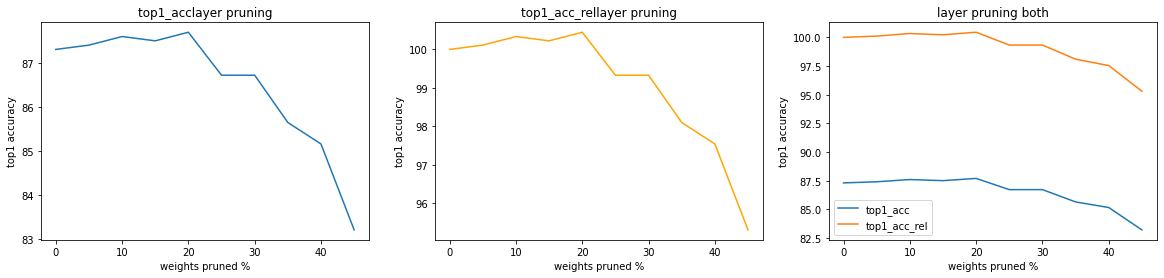

In [ ]:
plot_layer(layer_pruning, 'layer pruning')

## Question 3: Layer-wise (Input) Channel Pruning

- Perform pruning using `prune.ln_structured` on each layer of pretrained VGG16 using various sparsity targets.
- Prune along the input channels for conv layers and input dimension for linear layers
- Do not prune the first conv layer
- Each layer should be pruned away at 5% increments from 5% to 45% total pruning of the model.
- Save a copy of each pruned model in a dictionary.
- Plot the top-1 accuracy against weight pruned from 0% to 45% (use the original VGG16 for 0%).
- What do you observe? Why does layer-wise channel pruning perform better/worse than layer-wise unstructured pruning?
<br>
In layer wise channel pruning, the accuracy drops off as we increase the prune rate. This is because we are not allowing information to go into the next layers in the channel approach .

In [ ]:
# prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
# channel_pruning = {} # Dictionary to store channel pruning results
# for prune_rate in prune_rate_list:
#     model = orig_model#TODO: load pretrained model
#     convs_to_prune = () #TODO: Add conv layers to prune (except the first conv layer)
#     linears_to_prune = () #TODO: Add linear layers to prune
#     #TODO: Prune model
#     channel_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
#     channel_pruning[prune_rate]['model'] = model # Copy pruned model to dictionary
#     # TODO Run validation on the pruned model
#     channel_pruning[prune_rate]['top1_acc'] = None # TODO fill with top1 accuracy
#     channel_pruning[prune_rate]['top1_acc_rel'] = None # Percent accuracy compared to original model
#     print(f'Top1 accuracy for prune amount {prune_rate}%: {channel_pruning[prune_rate]["top1_acc"]}%')
#     print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {channel_pruning[prune_rate]["top1_acc_rel"]}%')

# TODO plot the results

prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
channel_pruning = {} # Dictionary to store global pruning results
for prune_rate in prune_rate_list:
    model = models.vgg16(pretrained = True) #TODO: load pretrained model

    convs_to_prune = (
        (model.features[0], 'weight'), # conv1 of VGG16
        (model.features[2], 'weight'),
        (model.features[5], 'weight'),
        (model.features[7], 'weight'),
        (model.features[10], 'weight'),
        (model.features[12], 'weight'),
        (model.features[14], 'weight'),
        (model.features[17], 'weight'),
        (model.features[19], 'weight'),
        (model.features[21], 'weight'),
        (model.features[24], 'weight'),
        (model.features[26], 'weight'),
        (model.features[28], 'weight'),
    )
    linears_to_prune = (
        (model.classifier[0], 'weight'),
        (model.classifier[3], 'weight'),
        # (model.classifier[6], 'weight'),
    )
    #TODO: Prune model
    for param, name in convs_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate/100.0, n=2, dim=0)
    for param, name in linears_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate/100.0, n=2, dim=1)
    # #TODO: make the pruning permanent to increase speed

    for param, name in convs_to_prune:
        prune.remove(param, name)
    for param, name in linears_to_prune:
        prune.remove(param, name)
    
    channel_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    channel_pruning[prune_rate]['model'] = model.state_dict() # Copy pruned model to dictionary
    #TODO Run validation on the pruned model
    pruned_acc, pruned_time = validate_model(model, val_dataloader, 1024, device = device_to_use)
    print(f'Validation Finished. Pruned Time: {pruned_time:.1f}s. Pruned Accuracy: {pruned_acc:.1f}%')
    print(f'Speedup: {orig_time/pruned_time}x. Accuracy drop: {orig_acc-pruned_acc}%')
    channel_pruning[prune_rate]['top1_acc'] = pruned_acc # TODO fill with top1 accuracy
    channel_pruning[prune_rate]['top1_acc_rel'] = pruned_acc/orig_acc*100 # Percent accuracy compared to original model
    print(f'Top1 accuracy for prune amount {prune_rate}%: {channel_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {channel_pruning[prune_rate]["top1_acc_rel"]}%')

# TODO plot the results


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[200] 84.5000%
[400] 76.7500%
[600] 78.1667%
[800] 80.8750%
[1000] 80.5000%
Validation Finished. Pruned Time: 19.0s. Pruned Accuracy: 80.6%
Speedup: 1.0037633634783514x. Accuracy drop: 6.73828125%
Top1 accuracy for prune amount 5%: 80.56640625%
Top1 accuracy (rel) for prune amount 5%: 92.28187919463086%
[200] 80.5000%
[400] 66.0000%
[600] 65.6667%
[800] 70.6250%
[1000] 70.6000%
Validation Finished. Pruned Time: 18.9s. Pruned Accuracy: 70.6%
Speedup: 1.009182567277392x. Accuracy drop: 16.69921875%
Top1 accuracy for prune amount 10%: 70.60546875%
Top1 accuracy (rel) for prune amount 10%: 80.87248322147651%
[200] 54.0000%
[400] 41.0000%
[600] 38.3333%
[800] 42.5000%
[1000] 42.9000%
Validation Finished. Pruned Time: 19.4s. Pruned Accuracy: 43.2%
Speedup: 0.9813102900919451x. Accuracy drop: 44.140625%
Top1 accuracy for prune amount 15%: 43.1640625%
Top1 accuracy (rel) for prune amount 15%: 49.44071588366891%
[200] 22.5000%
[400] 15.5000%
[600] 15.1667%
[800] 17.3750%
[1000] 15.8000%
Validat

In [ ]:
plot_channel(channel_pruning, 'channel pruning')

## Question 4: Layer-wise (Input) Channel Pruning (Continued)

In this question, we harden the channel pruning by removing the channels
- Collect the number of non-zero input channels for each layer
- Instantiate a new model based on the number of non-zero input channels
- Remember that the output channels of previous layer should match the input channels for current layer
- Pay special attention to the last convolution layer and first linear layer
- Copy over the the non-zero weights from the pruned model to the hardened model
- Calculate the run time and model size for the original VGG16 and the hardened VGG16s
- Plot the **relative** top-1 accuracy, run time and model size from 0% to 45% pruned VGG16
- What do you observe? What is the trade-off between accuracy, run time, and model size?
<br>
<br>
*************************
Answer - Lower the model size, smaller the runtime, and accuracy is also lower. 
<br>
Similarly, more the size, more the runtime and higher the accuracy. 

In [ ]:
# prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
# # prune_rate_list = [45] # List of prune rate to test from 5-45 inclusive with step of 5
# hardened_pruning = {} # Dictionary to store hardened pruning results
# for prune_rate in prune_rate_list:
#     hardened_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
#     #TODO: Collect the number of non-zero channels for each layer
#     model = models.vgg16(pretrained = False) #TODO: load pretrained model
#     model.eval()
#     # x = model.features[0]
#     # print(x)
#     # print("******************")

#     convs_to_prune = (
#         (model.features[0], 'weight'), # conv1 of VGG16
#         (model.features[2], 'weight'),
#         (model.features[5], 'weight'),
#         (model.features[7], 'weight'),
#         (model.features[10], 'weight'),
#         (model.features[12], 'weight'),
#         (model.features[14], 'weight'),
#         (model.features[17], 'weight'),
#         (model.features[19], 'weight'),
#         (model.features[21], 'weight'),
#         (model.features[24], 'weight'),
#         (model.features[26], 'weight'),
#         (model.features[28], 'weight'),
#     )
#     linears_to_prune = (
#         (model.classifier[0], 'weight'),
#         (model.classifier[3], 'weight'),
#         (model.classifier[6], 'weight'),
#     )
#     #TODO: Prune model
#     for param, name in convs_to_prune:
#         prune.ln_structured(param, name=name, amount=prune_rate/100.0, n=2, dim=0) 
#         # dim = 0 for channel - output pruning - source: https://towardsdatascience.com/how-to-prune-neural-networks-with-pytorch-ebef60316b91
#     for param, name in linears_to_prune:
#         prune.ln_structured(param, name=name, amount=prune_rate/100.0, n=2, dim=1)
#         # dim = 1 for disconnecting all connections to one input - source: https://towardsdatascience.com/how-to-prune-neural-networks-with-pytorch-ebef60316b91
#     # #TODO: make the pruning permanent to increase speed

#     # for param, name in convs_to_prune:
#     #     prune.remove(param, name)
#     # for param, name in linears_to_prune:
#     #     prune.remove(param, name)

#     pruned_acc, pruned_time = validate_model(orig_model, val_dataloader, 1024, device = device_to_use)
    
#     #TODO: Instantiate a new model based on collected number of non-zero channels
#     # print(list(model.named_parameters()))
#     weight_list = []
#     for name, param in model.named_buffers():
#       to_remove = 0
#       counter = 0
#       hardened_pruning[prune_rate]['new_weights'] = np.array([])
#       # layer_list = [model.features[0],model.features[2],model.features[5],model.features[7],model.features[10],model.features[12],model.features[14],model.features[17],model.features[19],model.features[21],model.features[24],model.features[26],model.features[28]]
#       # layer_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]
#       if('weight' in name):
#         x = param.detach()
#         # print(torch.count_nonzero(x).item(), "non zero items of a layer")
#         # print(torch.numel(x), "total items of a layer")
#         nz_x = torch.count_nonzero(x).item()
#         for each in x:
#           nz = torch.count_nonzero(each).item()
#           total = torch.numel(each)
#           if(total-nz == total):
#             to_remove += 1
#         z = torch.unique(x)
#         weight_list.append(z)

        
#         print("prune_rate =",prune_rate," / ", name,'/',x.shape,' / to remove', to_remove)
        
#     """
#     changing layer and weights
#     """
#     # temp = models.vgg16(pretrained = False)
#     # print(temp)
#     # net = temp
#     # net.features[0] = nn.Conv2d(3, 62, 3, 1, 1)
#     # x = net.classifier[0].weight
#     # z = torch.zeros(x.shape)
#     # net.classifier[0].weight = nn.Parameter(z)
#     # print(net.features[0].weight)
#     model.features[0] = nn.Conv2d(3, 64-round((prune_rate/100.0)*64), 3, 1, 1)#instantiating a new model
#     model.features[0].weight = nn.Parameter(weight_list[0])#updating the weights
#     model.features[2] = nn.Conv2d(64-round((prune_rate/100.0)*64), 64-round((prune_rate/100.0)*64), 3, 1, 1)#instantiating a new model
#     model.features[2].weight = nn.Parameter(weight_list[1])#updating the weights
#     model.features[5] = nn.Conv2d(64-round((prune_rate/100.0)*64), 128-round((prune_rate/100.0)*128), 3, 1, 1)#instantiating a new model
#     model.features[5].weight = nn.Parameter(weight_list[2])#updating the weights
#     model.features[7] = nn.Conv2d(128-round((prune_rate/100.0)*128),128-round((prune_rate/100.0)*128), 3, 1, 1)#instantiating a new model
#     model.features[7].weight = nn.Parameter(weight_list[3])#updating the weights
#     model.features[10] = nn.Conv2d(128-round((prune_rate/100.0)*128),256-round((prune_rate/100.0)*256), 3, 1, 1)#instantiating a new model
#     model.features[10].weight = nn.Parameter(weight_list[4])#updating the weights
#     model.features[12] = nn.Conv2d(256-round((prune_rate/100.0)*256),256-round((prune_rate/100.0)*256), 3, 1, 1)#instantiating a new model
#     model.features[12].weight = nn.Parameter(weight_list[5])#updating the weights
#     model.features[14] = nn.Conv2d(256-round((prune_rate/100.0)*256),256-round((prune_rate/100.0)*256), 3, 1, 1)#instantiating a new model
#     model.features[14].weight = nn.Parameter(weight_list[6])#updating the weights
#     model.features[17] = nn.Conv2d(256-round((prune_rate/100.0)*256), 512-round((prune_rate/100.0)*512), 3, 1, 1)#instantiating a new model
#     model.features[17].weight = nn.Parameter(weight_list[7])#updating the weights
#     model.features[19] = nn.Conv2d(512-round((prune_rate/100.0)*512), 512-round((prune_rate/100.0)*512), 3, 1, 1)#instantiating a new model
#     model.features[19].weight = nn.Parameter(weight_list[8])#updating the weights
#     model.features[21] = nn.Conv2d(512-round((prune_rate/100.0)*512),512-round((prune_rate/100.0)*512), 3, 1, 1)#instantiating a new model
#     model.features[21].weight = nn.Parameter(weight_list[9])#updating the weights
#     model.features[24] = nn.Conv2d(512-round((prune_rate/100.0)*512), 512-round((prune_rate/100.0)*512), 3, 1, 1)#instantiating a new model
#     model.features[24].weight = nn.Parameter(weight_list[10])#updating the weights
#     model.features[26] = nn.Conv2d(512-round((prune_rate/100.0)*512), 512-round((prune_rate/100.0)*512), 3, 1, 1)#instantiating a new model
#     model.features[26].weight = nn.Parameter(weight_list[11])#updating the weights
#     model.features[28] = nn.Conv2d(512-round((prune_rate/100.0)*512),512, 3, 1, 1) #not pruning the last layer as we are pruning output layers
#     model.features[28].weight = nn.Parameter(weight_list[12])#updating the weights

#     # for param, name in convs_to_prune:
#     #     prune.remove(param, name)
#     # for param, name in linears_to_prune:
#     #     prune.remove(param, name)

#     # nz_x = nonzero(x)
#         # print(nz_x)

#     # hardened_model = model.cuda() #layers not reinstantiated because none of the output channels were filled with all zeros
    
    
#     # hardened_pruning[prune_rate]['model'] = model.state_dict() # Copy original model to dictionary 

#     hardened_pruning[prune_rate]['top1_acc'] = channel_pruning[prune_rate]['top1_acc'] # TODO just copy from channel pruning
#     hardened_pruning[prune_rate]['top1_acc_rel'] = channel_pruning[prune_rate]['top1_acc_rel'] # TODO just copy from channel pruning
    
#     print(f'Validation Finished. Pruned Time: {pruned_time:.1f}s. Pruned Accuracy: {pruned_acc:.1f}%')
#     print(f'Speedup: {orig_time/pruned_time}x. Accuracy drop: {orig_acc-pruned_acc}%')
#     hardened_pruning[prune_rate]['run_time'] = pruned_time # TODO Collect run time of the hardened model
#     hardened_pruning[prune_rate]['run_time_rel'] = orig_time # TODO Collect run time (relative) of the hardened model
#     temp_size = get_size_of_model(model)
#     hardened_pruning[prune_rate]['model_size'] =  temp_size# TODO Collect model size of the hardened model
#     # hardened_pruning[prune_rate]['model_size_rel'] = get_size_of_model(orig_model)/temp_size*100 # TODO Collect model size (relative) of the hardened model
#     hardened_pruning[prune_rate]['model_size_rel'] = temp_size/get_size_of_model(orig_model) # TODO Collect model size (relative) of the hardened model

  


In [ ]:
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
hardened_pruning = {} # Dictionary to store global pruning results
for prune_rate in prune_rate_list:
    model = models.vgg16(pretrained = True) #TODO: load pretrained model

    convs_to_prune = (
        (model.features[0], 'weight'), # conv1 of VGG16
        (model.features[2], 'weight'),
        (model.features[5], 'weight'),
        (model.features[7], 'weight'),
        (model.features[10], 'weight'),
        (model.features[12], 'weight'),
        (model.features[14], 'weight'),
        (model.features[17], 'weight'),
        (model.features[19], 'weight'),
        (model.features[21], 'weight'),
        (model.features[24], 'weight'),
        (model.features[26], 'weight'),
        (model.features[28], 'weight'),
    )
    linears_to_prune = (
        (model.classifier[0], 'weight'),
        (model.classifier[3], 'weight'),
        # (model.classifier[6], 'weight'),
    )
    #TODO: Prune model
    for param, name in convs_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate/100.0, n=2, dim=0)
    for param, name in linears_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate/100.0, n=2, dim=1)
    # #TODO: make the pruning permanent to increase speed

    # for param, name in convs_to_prune:
    #     prune.remove(param, name)
    # for param, name in linears_to_prune:
    #     prune.remove(param, name)
    
    hardened_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    # hardened_pruning[prune_rate]['model'] = model.state_dict() # Copy pruned model to dictionary
    #TODO Run validation on the pruned model
    pruned_acc, pruned_time = validate_model(model, val_dataloader, 1024, device = device_to_use)
    print(f'Validation Finished. Pruned Time: {pruned_time:.1f}s. Pruned Accuracy: {pruned_acc:.1f}%')
    print(f'Speedup: {orig_time/pruned_time}x. Accuracy drop: {orig_acc-pruned_acc}%')
    hardened_pruning[prune_rate]['top1_acc'] = pruned_acc # TODO fill with top1 accuracy
    hardened_pruning[prune_rate]['top1_acc_rel'] = pruned_acc/orig_acc*100 # Percent accuracy compared to original model
    print(f'Top1 accuracy for prune amount {prune_rate}%: {hardened_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {hardened_pruning[prune_rate]["top1_acc_rel"]}%')

    hardened_pruning[prune_rate]['run_time'] = pruned_time # TODO Collect run time of the hardened model
    hardened_pruning[prune_rate]['run_time_rel'] = orig_time # TODO Collect run time (relative) of the hardened model


    class VGG16(nn.Module):
        def __init__(self, num_classes=10):
            super(VGG16, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, round(64*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(64*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer2 = nn.Sequential(
                nn.Conv2d(round(64*(1-(prune_rate/100.0))), round(64*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(64*(1-(prune_rate/100.0)))),
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(round(64*(1-(prune_rate/100.0))), round(128*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(128*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(round(128*(1-(prune_rate/100.0))), round(128*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(128*(1-(prune_rate/100.0)))),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer5 = nn.Sequential(
                nn.Conv2d(round(128*(1-(prune_rate/100.0))), round(256*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(256*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer6 = nn.Sequential(
                nn.Conv2d(round(256*(1-(prune_rate/100.0))), round(256*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(256*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer7 = nn.Sequential(
                nn.Conv2d(round(256*(1-(prune_rate/100.0))), round(256*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(256*(1-(prune_rate/100.0)))),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer8 = nn.Sequential(
                nn.Conv2d(round(256*(1-(prune_rate/100.0))),round(512*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(512*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer9 = nn.Sequential(
                nn.Conv2d(round(512*(1-(prune_rate/100.0))), round(512*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(512*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer10 = nn.Sequential(
                nn.Conv2d(round(512*(1-(prune_rate/100.0))), round(512*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(512*(1-(prune_rate/100.0)))),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer11 = nn.Sequential(
                nn.Conv2d(round(512*(1-(prune_rate/100.0))), round(512*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(512*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer12 = nn.Sequential(
                nn.Conv2d(round(512*(1-(prune_rate/100.0))), round(512*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(512*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.layer13 = nn.Sequential(
                nn.Conv2d(round(512*(1-(prune_rate/100.0))), round(512*(1-(prune_rate/100.0))), kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(round(512*(1-(prune_rate/100.0)))),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(round(7*7*512*(1-(prune_rate/100.0))), round(4096*(1-(prune_rate/100.0)))),
                nn.ReLU())
            self.fc1 = nn.Sequential( 
                nn.Dropout(0.5),
                nn.Linear(round(4096*(1-(prune_rate/100.0))), 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes)) # not pruning this layer since we are pruning output channels
            
        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = self.layer6(out)
            out = self.layer7(out)
            out = self.layer8(out)
            out = self.layer9(out)
            out = self.layer10(out)
            out = self.layer11(out)
            out = self.layer12(out)
            out = self.layer13(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
    model = VGG16()
    weight_list = []
    for name, param in model.named_buffers():
      to_remove = 0
      counter = 0
      hardened_pruning[prune_rate]['new_weights'] = np.array([])
      # layer_list = [model.features[0],model.features[2],model.features[5],model.features[7],model.features[10],model.features[12],model.features[14],model.features[17],model.features[19],model.features[21],model.features[24],model.features[26],model.features[28]]
      # layer_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]
      if('weight' in name):
        x = param.detach()
        # print(torch.count_nonzero(x).item(), "non zero items of a layer")
        # print(torch.numel(x), "total items of a layer")
        nz_x = torch.count_nonzero(x).item()
        for each in x:
          nz = torch.count_nonzero(each).item()
          total = torch.numel(each)
          if(total-nz == total):
            to_remove += 1
        z = torch.unique(x)
        weight_list.append(z)
        """
        changing layer and weights
        """
        # temp = models.vgg16(pretrained = False)
        # print(temp)
        # net = temp
        # net.features[0] = nn.Conv2d(3, 62, 3, 1, 1)
        # x = net.classifier[0].weight
        # z = torch.zeros(x.shape)
        # net.classifier[0].weight = nn.Parameter(z)
        # print(net.features[0].weight)
        
        model.features[0].weight = nn.Parameter(weight_list[0])#updating the weights
        
        model.features[2].weight = nn.Parameter(weight_list[1])#updating the weights
        
        model.features[5].weight = nn.Parameter(weight_list[2])#updating the weights
        
        model.features[7].weight = nn.Parameter(weight_list[3])#updating the weights
        
        model.features[10].weight = nn.Parameter(weight_list[4])#updating the weights
        
        model.features[12].weight = nn.Parameter(weight_list[5])#updating the weights
        
        model.features[14].weight = nn.Parameter(weight_list[6])#updating the weights
        
        model.features[17].weight = nn.Parameter(weight_list[7])#updating the weights
        
        model.features[19].weight = nn.Parameter(weight_list[8])#updating the weights
        
        model.features[21].weight = nn.Parameter(weight_list[9])#updating the weights
        
        model.features[24].weight = nn.Parameter(weight_list[10])#updating the weights
        
        model.features[26].weight = nn.Parameter(weight_list[11])#updating the weights
        
        model.features[28].weight = nn.Parameter(weight_list[12])#updating the weights
        
    # print(get_size_of_model(model))
    temp_size = get_size_of_model(model)
    hardened_pruning[prune_rate]['model_size'] =  temp_size# TODO Collect model size of the hardened model
    hardened_pruning[prune_rate]['model_size_rel'] = temp_size/get_size_of_model(orig_model)*100 # TODO Collect model size (relative) of the hardened model


# TODO plot the results


[200] 84.5000%
[400] 76.7500%
[600] 78.1667%
[800] 80.8750%
[1000] 80.5000%
Validation Finished. Pruned Time: 18.7s. Pruned Accuracy: 80.6%
Speedup: 1.0758909398390821x. Accuracy drop: 6.73828125%
Top1 accuracy for prune amount 5%: 80.56640625%
Top1 accuracy (rel) for prune amount 5%: 92.28187919463086%
[200] 80.5000%
[400] 66.0000%
[600] 65.6667%
[800] 70.6250%
[1000] 70.6000%
Validation Finished. Pruned Time: 18.2s. Pruned Accuracy: 70.6%
Speedup: 1.1052041638818246x. Accuracy drop: 16.69921875%
Top1 accuracy for prune amount 10%: 70.60546875%
Top1 accuracy (rel) for prune amount 10%: 80.87248322147651%
[200] 54.0000%
[400] 41.0000%
[600] 38.3333%
[800] 42.5000%
[1000] 42.9000%
Validation Finished. Pruned Time: 18.3s. Pruned Accuracy: 43.2%
Speedup: 1.1025464803641933x. Accuracy drop: 44.140625%
Top1 accuracy for prune amount 15%: 43.1640625%
Top1 accuracy (rel) for prune amount 15%: 49.44071588366891%
[200] 22.5000%
[400] 15.5000%
[600] 15.1667%
[800] 17.3750%
[1000] 15.8000%
Valida

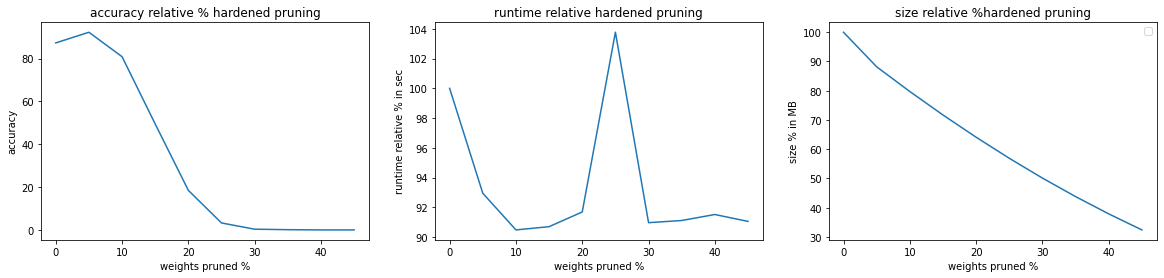

In [ ]:
plot_hardened(hardened_pruning, 'hardened pruning')

In [ ]:
for each in range(5,50,5):
  print(hardened_pruning[each]['model_size'])

488.036226
441.26989
396.859586
354.779522
314.92781
277.431106
242.395778
209.717826
179.36877


## (Optional) Question 5: Regularization to promote sparsity
Using lab 1 as guidance, load a pretrained trained VGG16 model without batch normalization (without `_bn` suffix) below and train it using Tiny ImageNet. The specifications are listed below:

* The data transform should be according to VGG16_weights parameter description found [here](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html).
* Use a batch size of `32`
* Use the default `CrossEntropyLoss` loss function as a criterion
* Use stochastic gradient descent with learning rate of `1e-3`, momentum of `0.9`, weight decay of `1e-4`
* Use a momentum value of `0.9`
* Use a weight decay of `1e-4`
* Train for 10 Epochs
* Train the model with GPU
* save the trained model in a file called `original_net`

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

# Define main data directory
data_dir = Path('tiny-imagenet-200') # Original images come in shapes of [3,64,64]

# Define training and validation data paths
train_dir = data_dir / 'train'
valid_dir = data_dir / 'val'

In [ ]:
from torch.utils.data.datapipes.datapipe import T
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
trainset = datasets.ImageFolder(train_dir, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)  # Batch size of 32
criterion = nn.CrossEntropyLoss() # Store loss function in this variable
original_net = models.efficientnet_b0()
print(original_net)

In [ ]:
optimizer = torch.optim.SGD(original_net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4) # Store SGD optimizer in this variable

# TODO write reuseable validation and training functions here to reduce work
# TODO fill out the above variables
# TODO run training
# TODO save the trained model to a file called original_net

## (Optional) Question 6: Accuracy on TinyImageNet

Run validation over the entire validation set and report the top 1 and top 5 accuracy.

In [ ]:
validset = datasets.ImageFolder(valid_dir, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=32, num_workers=2)
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in validloader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = original_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

## (Optional) Question 7: Iterative Pruning
Follow the iterative pruning method described in lecture co-design II. Run three iterations of iterative pruning--training for an entire epoch each iteration. The final target prune rate follows the following equation $final = 1 - (1 - r)^n$. Therefore, ensure to pick the correct iterative prune rate, $r$, to meet the final prune rate target $final$. The final prune rate targets are captured in the `prune_rate_list`. $n$ is the number of iterations.

- Compare your accuracies to Q1-4.

In [ ]:
iterative_pruning = {} # Dictionary to store pruned model after retraining and accuracy for each prune rate target
iterative_prune_rate = None # iterative prune rate needed to achieve `prune_rate` final target when pruned three times
for prune_rate in prune_rate_list:
    iterative_pruning[prune_rate] = {} # Dictionary to store accuracy and model for each sparsity value
    iterative_pruning[prune_rate]['model'] = copy.deepcopy(original_net) # Copy original model to dictionary
    # TODO Run iterative pruning three times
    iterative_pruning[prune_rate]['top1_acc'] = None # TODO fill with top1 accuracy
    iterative_pruning[prune_rate]['top1_acc_loss'] = None # Percent accuracy loss compared to original model
    print(f'Top1 accuracy for sparsity {prune_rate}%: {iterative_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy loss for sparsity {prune_rate}%: {iterative_pruning[prune_rate]["top1_acc_loss"]}%')
# TODO save the trained model to a file called iterative_pruned_net